In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error as mean_squared_error
import math

In [24]:
df = pd.read_stata("../data/variables_productos_primarios.dta",index_col="fecha")
df = df.drop(["mes","anio"],axis=1)
df["pp"] = df.pp / 1_000_000
df.index = df.index.to_period('M')

In [25]:
meses_testeo = 24
meses_prediccion = 6
train = df[:-meses_testeo].copy()
test = df.copy()

In [26]:
y_train = train["pp"]
y_test = test["pp"]
exog = ["ip", "pre", "itcr"]
X_train =train[exog]
X_test = test[exog]
# MODEL_ORDERS = {
#     'pp': {'order':(1,1,1), 'seasonal_order':(0,1,1,12)},
#                 # 'pp': {'order':(1,0,0), 'seasonal_order':(1,0,1,12)},
#                 'itcr': {'order':(5,1,5), 'seasonal_order':None},
#                 'ip': {'order':(4,1,4), 'seasonal_order':(0,1,1,12)},
#                 'pre': {'order':(8,0,9), 'seasonal_order':(1,0,1,12)}
#                 }

MODEL_ORDERS = {
    'pp': {'order':(8,0,3), 'seasonal_order':(0,1,1,12)},
    'itcr': {'order':(1,0,4), 'seasonal_order':None},
    'ip': {'order':(4,0,5), 'seasonal_order':(0,1,1,12)},
    'pre': {'order':(8,0,9), 'seasonal_order':(0,0,0,12)}
                }

1. Estimar las exogenas n meses en train  (X_new_train)
2. Estimar las exogenas n meses en test (X_new_test)
3. Estimar la endógena n meses en train (usando X_new_train) 
4. Estimar la endógena n meses en test (usando X_new_test)

In [27]:
train_model_itcr = SARIMAX(train[["itcr"]],order = MODEL_ORDERS['itcr']['order'], seasonal_order=MODEL_ORDERS['itcr']['seasonal_order'])
train_model_ip = SARIMAX(train[["ip"]], order=MODEL_ORDERS['ip']['order'], seasonal_order=MODEL_ORDERS['ip']['seasonal_order'])
train_model_pre = SARIMAX(np.log(train[["pre"]]+1), order=MODEL_ORDERS['pre']['order'], seasonal_order=MODEL_ORDERS['pre']['seasonal_order'])

test_model_itcr = SARIMAX(test[["itcr"]],order = MODEL_ORDERS['itcr']['order'], seasonal_order=MODEL_ORDERS['itcr']['seasonal_order'])
test_model_ip = SARIMAX(test[["ip"]], order=MODEL_ORDERS['ip']['order'], seasonal_order=MODEL_ORDERS['ip']['seasonal_order'])
test_model_pre = SARIMAX(np.log(test[["pre"]]+1), order=MODEL_ORDERS['pre']['order'], seasonal_order=MODEL_ORDERS['pre']['seasonal_order'])

In [28]:
modelos_exogenas = {train_model_ip:"ip", train_model_pre:"pre", train_model_itcr:"itcr"}
for modelo in modelos_exogenas:
    variable = modelos_exogenas[modelo]
    order = MODEL_ORDERS[variable]["order"]
    seasonal_order = MODEL_ORDERS[variable]["seasonal_order"]
    seasonal_order = "" if not seasonal_order else seasonal_order
    fitted = modelo.fit()
    forecast = fitted.forecast(meses_testeo)
    forecast = pd.concat([fitted.fittedvalues, forecast])
    if modelo == train_model_pre:
        forecast = np.exp(forecast) #Transformación de inversión
    obs_pred_df = pd.DataFrame({"observado":test[variable],
                                "prediccion": forecast})
    RMSE = round(math.sqrt(mean_squared_error(obs_pred_df["observado"], obs_pred_df["prediccion"])), 2)
    plot_predicc_obs_exog = go.Figure()
    # plot_predicc_obs_exog.add_trace(go.Scatter(x=obs_pred_df.index, y = obs_pred_df["observado"], name = "Observación"))
    plot_predicc_obs_exog.add_trace(go.Scatter(x=df.index.to_timestamp(), y = df[variable], name = "Observación"))
    plot_predicc_obs_exog.add_trace(go.Scatter(x=obs_pred_df.index.to_timestamp(), y = obs_pred_df["prediccion"], name = "Predicción"))
    plot_predicc_obs_exog.add_vline(x = obs_pred_df.index.to_timestamp()[-meses_testeo], line_width=3, line_dash="dash", line_color="green")
    plot_predicc_obs_exog.update_layout(template = None, title_text =f"Testeo modelo para \"{variable}\"<br><sup>{order}{seasonal_order}. RMSE: {RMSE}",
    font_family = "georgia")
    plot_predicc_obs_exog.write_image(f"../output/testeo_exog_sarimax/testeo_exog_sarimax_{variable}.pdf")
    plot_predicc_obs_exog.show()

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [34]:
X_new_train = pd.DataFrame()
for modelo in modelos_exogenas:
    fitted = modelo.fit(disp=False)
    forecast = fitted.forecast(meses_testeo)
    # forecast = pd.concat([fitted.fittedvalues, forecast]) 
    if modelo == train_model_pre:
        forecast = np.exp(forecast)
    X_new_train[modelos_exogenas[modelo]] = forecast

X_new_test = pd.DataFrame()
for modelo in modelos_exogenas:
    fitted = modelo.fit(disp=False)
    forecast = fitted.forecast(meses_prediccion)
    # forecast = pd.concat([fitted.fittedvalues, forecast]) 
    if modelo == test_model_pre:
        forecast = np.exp(forecast)
    X_new_test[modelos_exogenas[modelo]] = forecast

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\marti\anaconda3\envs\my-

In [35]:
train_model_pp = SARIMAX(y_train, order=MODEL_ORDERS['pp']['order'], seasonal_order=MODEL_ORDERS['pp']['seasonal_order'],
                         exog=X_train)
test_model_pp = SARIMAX(y_test, order=MODEL_ORDERS['pp']['order'], seasonal_order=MODEL_ORDERS['pp']['seasonal_order'],
                        exog=X_test)

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



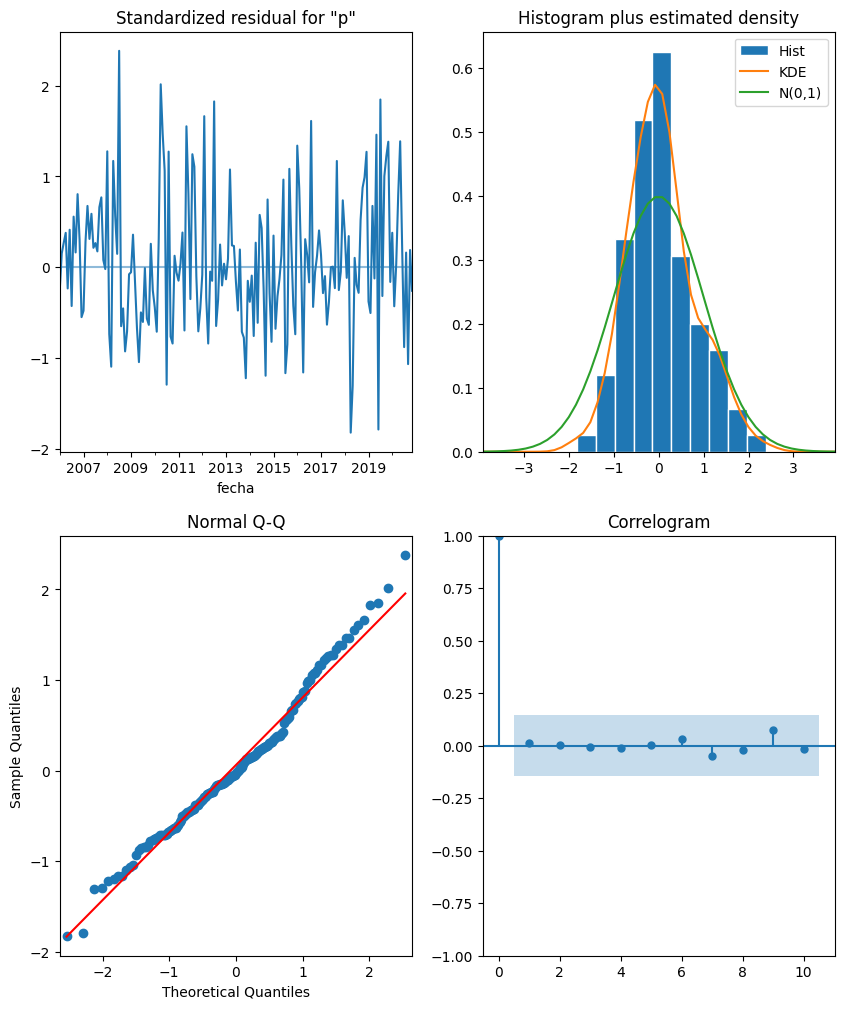

In [36]:
train_model_pp.fit().plot_diagnostics(figsize=(10, 12))
plt.show()

In [38]:
fitted = train_model_pp.fit(disp=False)
order_main = MODEL_ORDERS["pp"]["order"]
seasonal_order_main = MODEL_ORDERS["pp"]["seasonal_order"]
forecast_train = fitted.forecast(meses_testeo, exog = X_new_train)
forecast_train = pd.concat([fitted.fittedvalues, forecast_train])
obs_pred_df = pd.DataFrame({"observado":y_test,
                            "prediccion": forecast_train})
RMSE = round(math.sqrt(mean_squared_error(obs_pred_df["observado"], obs_pred_df["prediccion"])), 2)
plot_predicc_obs_exog = go.Figure()
plot_predicc_obs_exog.add_trace(go.Scatter(x=y_test.index.to_timestamp(), y = y_test, name = "Observación"))
plot_predicc_obs_exog.add_trace(go.Scatter(x=obs_pred_df.index.to_timestamp(), y = obs_pred_df["prediccion"], name = "Predicción"))
plot_predicc_obs_exog.add_vline(x = obs_pred_df.index[-meses_testeo].to_timestamp(), line_width=3, line_dash="dash", line_color="green")
plot_predicc_obs_exog.update_layout(template = None, title_text =f"Testeo del modelo para \"{'pp'}\"<br><sup>{order_main}{seasonal_order_main}. RMSE: {RMSE}",
font_family = "georgia")
plot_predicc_obs_exog.write_image("../output/testeo_exog_sarimax/testeo_endog_sarimax_pp.pdf")
plot_predicc_obs_exog.show()

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [40]:
fitted = test_model_pp.fit(disp=False)
forecast_test = fitted.forecast(meses_prediccion, exog = X_new_test)
forecast_test = pd.concat([fitted.fittedvalues, forecast_test])
obs_pred_test = pd.DataFrame({"observado":y_test,
                            "prediccion": forecast_test})
plot_predicc_obs_exog = go.Figure()
plot_predicc_obs_exog.add_trace(go.Scatter(x=y_test.index.to_timestamp(), y = y_test, name = "Observación"))
plot_predicc_obs_exog.add_trace(go.Scatter(x=obs_pred_test.index.to_timestamp(), y = obs_pred_test["prediccion"], name = "Predicción"))
plot_predicc_obs_exog.add_vline(x = obs_pred_test.index[-meses_prediccion].to_timestamp(), line_width=3, line_dash="dash", line_color="green")
plot_predicc_obs_exog.update_layout(template = None, title_text =f"Predicción a 6 meses usando modelo SARIMAX \"{'pp'}\"<br><sup>Modelo: {order_main}{seasonal_order_main}",
font_family = "georgia")
plot_predicc_obs_exog.write_image("../output/Prediccion_sarimax_plot.pdf")
plot_predicc_obs_exog.show()

c:\Users\marti\anaconda3\envs\my-proj\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

